In [45]:
import os 

import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
chen_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.run_meta.organized.tsv', sep='\t')
chen_metadata = chen_metadata[['Accession', 'SampleID', 'PatientID', 'TreatmentStage', 'TreatmentPoint', 'BiopsySite', 'MMR', 'MSI', 'TMB', 'Response', 'LibraryType']].copy()
chen_metadata = chen_metadata[(chen_metadata['LibraryType']=='scRNA-seq')].copy()
chen_metadata = chen_metadata[(chen_metadata['BiopsySite'].isin( ['Adjacent normal tissue', 'Tumor'] ))].copy()
chen_metadata['BiopsySite'] = chen_metadata['BiopsySite'].map( { 
                                                                'Adjacent normal tissue' : 'Normal', 
                                                                'Tumor' : 'Tumor', 
                                                                })
chen_metadata_SD = chen_metadata[(chen_metadata['Response']=='SD') & (chen_metadata['TreatmentStage']=='Pre')].copy()

## Read Adata

In [13]:
adata = list()
for tup in chen_metadata_SD.itertuples():
    if tup.BiopsySite == 'Tumor':
        PATH_adata = f'/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Tumor/{tup.Accession}/outs/filtered_feature_bc_matrix.scrublet.CellTypeLabeled.h5'
    else:
        PATH_adata = f'/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Adjacent_normal_tissue/{tup.Accession}/outs/filtered_feature_bc_matrix.scrublet.CellTypeLabeled.h5'
    adata_e = sc.read_h5ad(PATH_adata)
    adata.append( adata_e )
adata = sc.concat(adata)

## Standard Scanpy preprocessing

In [17]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [ ]:
# sc.pp.filter_cells(adata, min_genes=100)
# sc.pp.filter_genes(adata, min_cells=3)

In [21]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata.copy()
adata = adata[:, adata.var.highly_variable]

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


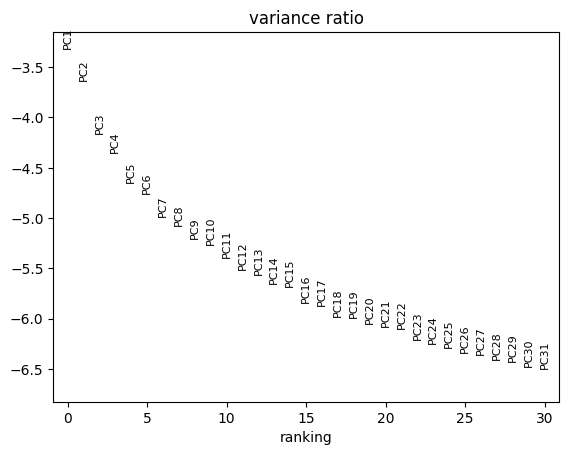

In [23]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata, )

2024-12-03 15:23:42.113060: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 15:23:42.166367: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 15:23:42.633841: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 15:23:42.787874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 15:23:42.952594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [57]:
sc.tl.leiden(adata, resolution=0.2)

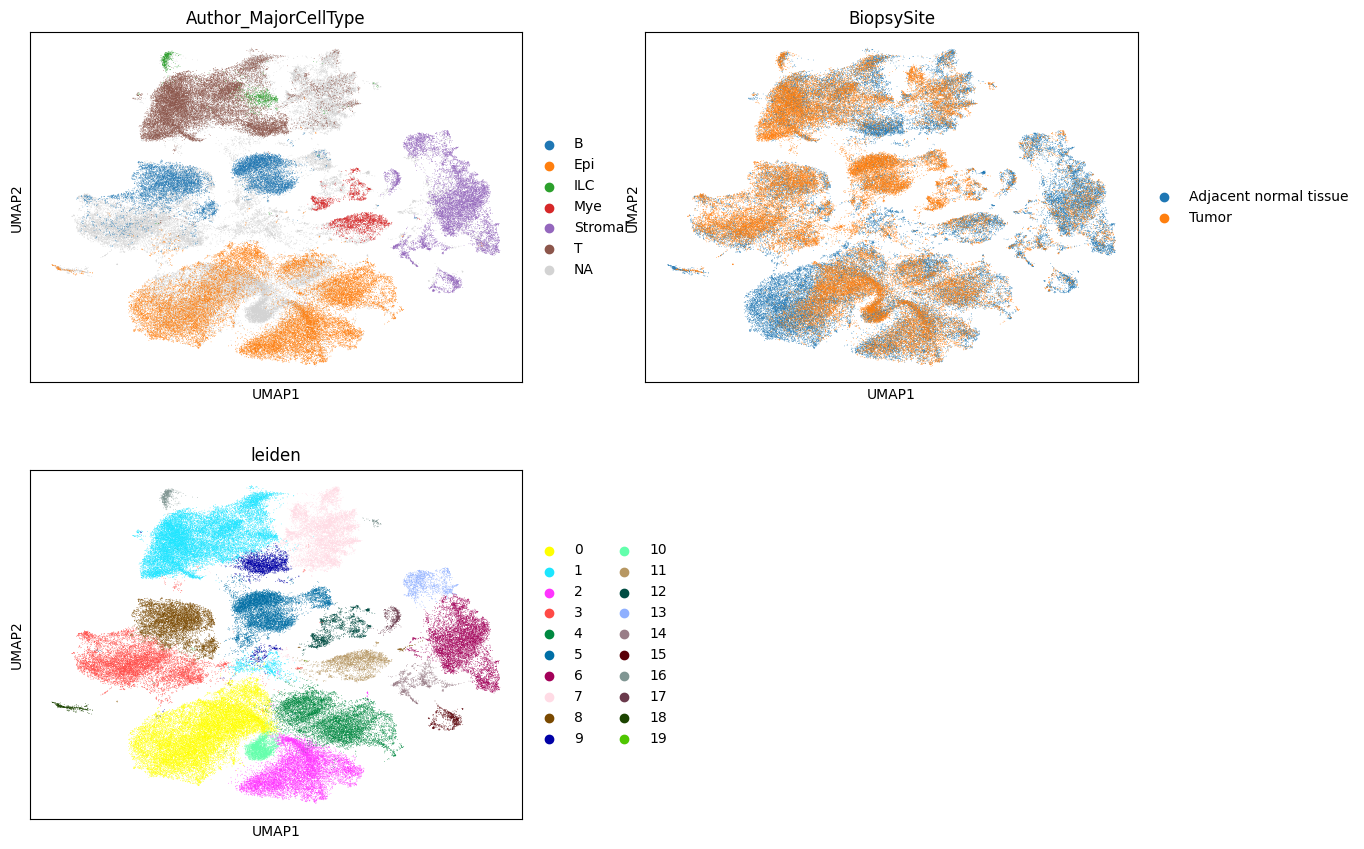

In [58]:
sc.pl.umap(adata, color=['Author_MajorCellType', 'BiopsySite', 'leiden'], ncols=2)

## Load NanoMnT results and overlay

In [40]:
DIR_cellranger_tumor = '/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Tumor'

nanomnt_combined = list()

for tup in chen_metadata_SD.itertuples():
    SampleAccession = tup.Accession
    PATH_nanomnt_out = f'{DIR_cellranger_tumor}/{SampleAccession}/outs/possorted_genome_bam.STR_allele_table.tsv'
    if os.path.exists(PATH_nanomnt_out)==False:
        print(f'NanoMnT output not found for {SampleAccession}, {tup.BiopsySite}')
        continue

    nanomnt_out = pd.read_csv(PATH_nanomnt_out, sep='\t', )
    nanomnt_out['BiopsySite']   = 'Tumor'
    nanomnt_out['Accession']    = SampleAccession 
    nanomnt_combined.append( nanomnt_out )

NanoMnT output not found for HRR1373488
NanoMnT output not found for HRR1373487
NanoMnT output not found for HRR1373486
NanoMnT output not found for HRR1373485
NanoMnT output not found for HRR1373772
NanoMnT output not found for HRR1373771
NanoMnT output not found for HRR1373770
NanoMnT output not found for HRR1373769


In [41]:
nanomnt_combined = pd.concat(nanomnt_combined)
nanomnt_combined.reset_index(inplace=True, drop=True)

col_read_STR_allele = list() 
for tup in nanomnt_combined.itertuples():
    try:
        int( tup.read_STR_allele )
        col_read_STR_allele.append( int( tup.read_STR_allele ) )
    except ValueError:
        col_read_STR_allele.append( int( tup.read_STR_length ) )
        
nanomnt_combined['read_STR_allele'] = col_read_STR_allele
nanomnt_combined.drop( "read_STR_length", axis=1, inplace=True )

In [44]:
nanomnt_combined['Diff'] = nanomnt_combined['read_STR_allele'] - nanomnt_combined['reference_STR_allele']

In [43]:
adata.obs['Identifier2'] = [ f'{tup.HRR_id}-{tup.Index}' for tup in adata.obs.itertuples() ]
nanomnt_combined['Identifier2'] = [ f'{tup.Accession}-{tup.CB}' for tup in nanomnt_combined.itertuples() ]

In [46]:
dict_Identifier2_to_STRinfo = dict()
for Identifier2, edf in nanomnt_combined.groupby("Identifier2"):
    dict_Identifier2_to_STRinfo[Identifier2] = [ np.mean(edf['Diff']), np.std(edf['Diff']), len(edf) ]
for Identifier2 in adata.obs['Identifier2']:
    try: dict_Identifier2_to_STRinfo[Identifier2]
    except KeyError: dict_Identifier2_to_STRinfo[Identifier2] = [ None, None, None ]

In [47]:
adata.obs['AvgSTRDiff'] = [ dict_Identifier2_to_STRinfo[Identifier2][0] for Identifier2 in adata.obs['Identifier2'] ] 
adata.obs['StdSTRDiff'] = [ dict_Identifier2_to_STRinfo[Identifier2][1] for Identifier2 in adata.obs['Identifier2'] ] 
adata.obs['NumSTRLoci'] = [ dict_Identifier2_to_STRinfo[Identifier2][2] for Identifier2 in adata.obs['Identifier2'] ] 

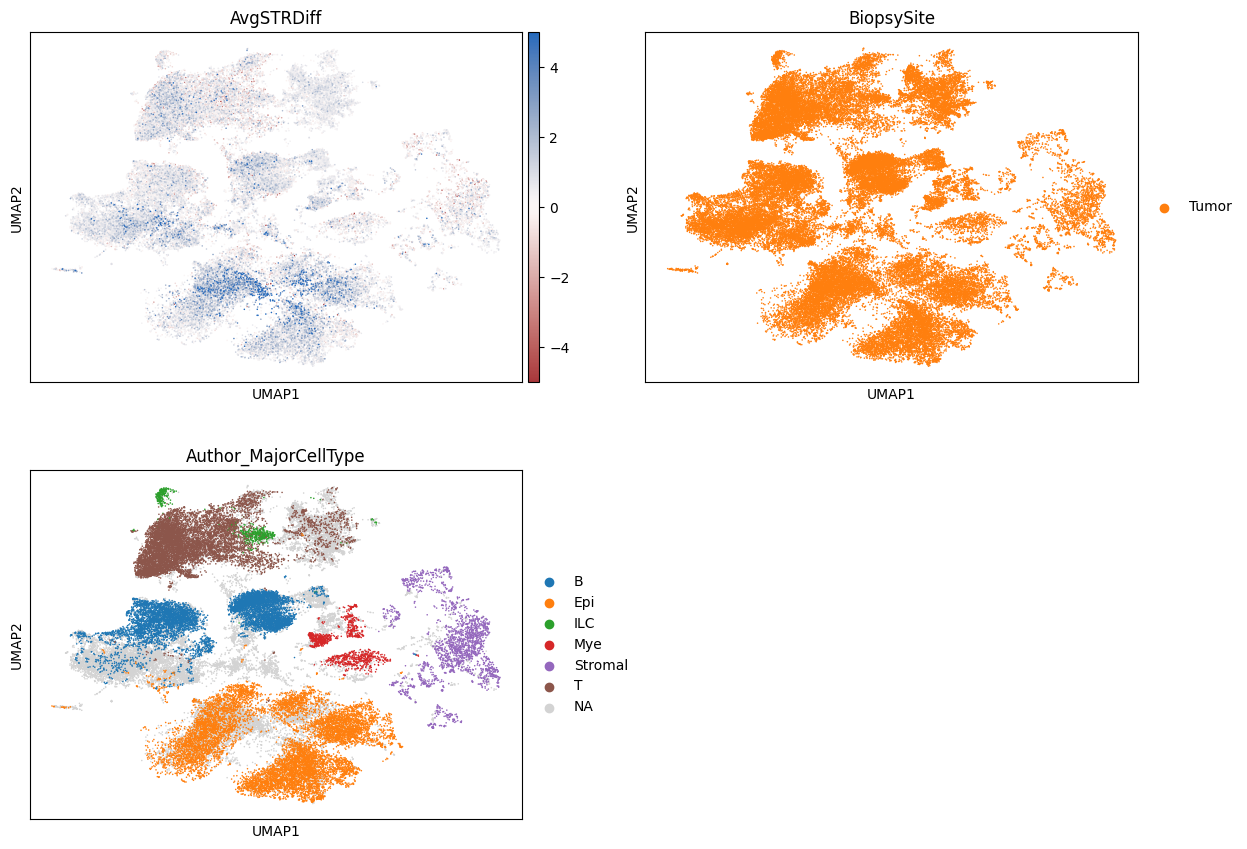

In [54]:
sc.pl.umap(adata[adata.obs['NumSTRLoci']>=10], color=['AvgSTRDiff', 'BiopsySite', 'Author_MajorCellType', ], 
           ncols=2, s=5, vmin=-5, vmax=5, cmap='vlag_r')

## Subset Epithelial cluster

In [74]:
adata_epi = adata[adata.obs['leiden'].isin(['0', '10', '2', '4'])].copy()
adata_epi = adata_epi.raw.to_adata()

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [97]:
sc.pp.highly_variable_genes(adata_epi, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_epi.raw = adata_epi.copy()
adata_epi = adata_epi[:, adata_epi.var.highly_variable]

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


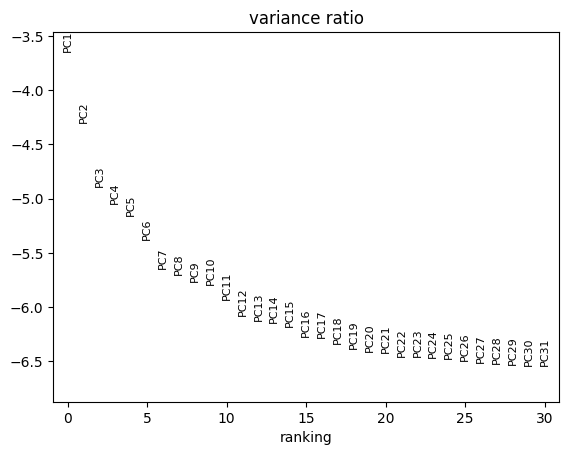

In [98]:
sc.pp.scale(adata_epi, max_value=10)
sc.tl.pca(adata_epi, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi, log=True)

In [99]:
sc.pp.neighbors(adata_epi, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi, )

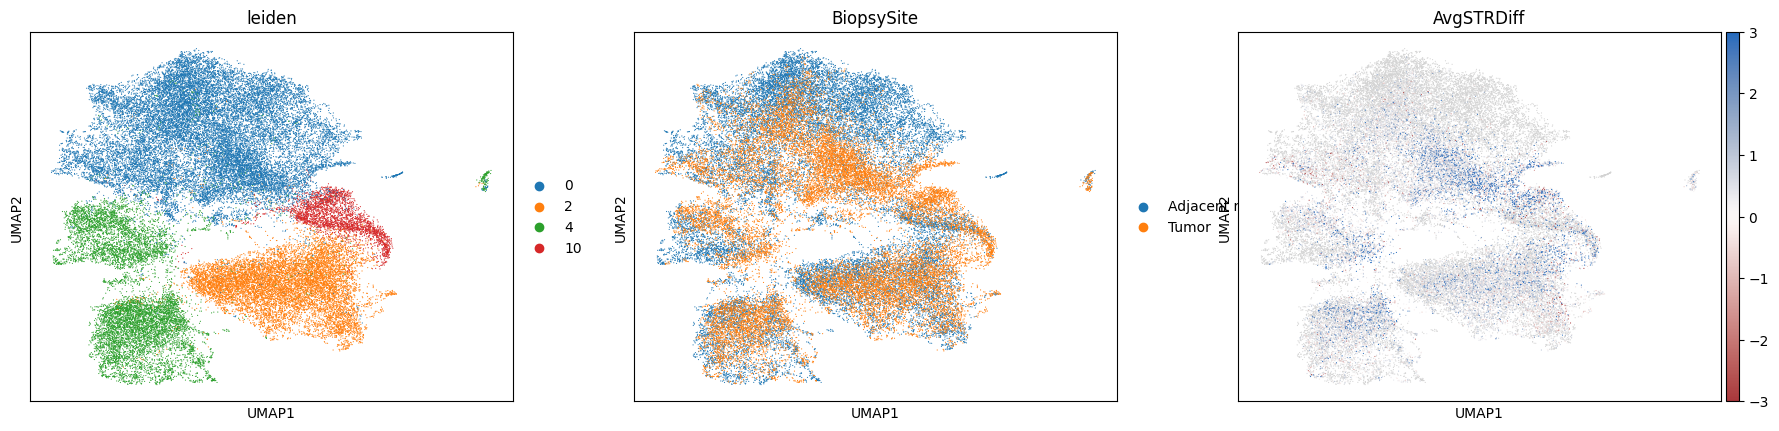

In [102]:
sc.pl.umap(adata_epi, color=['leiden', 'BiopsySite', 'AvgSTRDiff'], 
           vmin=-3, vmax=3, cmap='vlag_r')

In [103]:
sc.tl.leiden(adata_epi, resolution=0.2,)

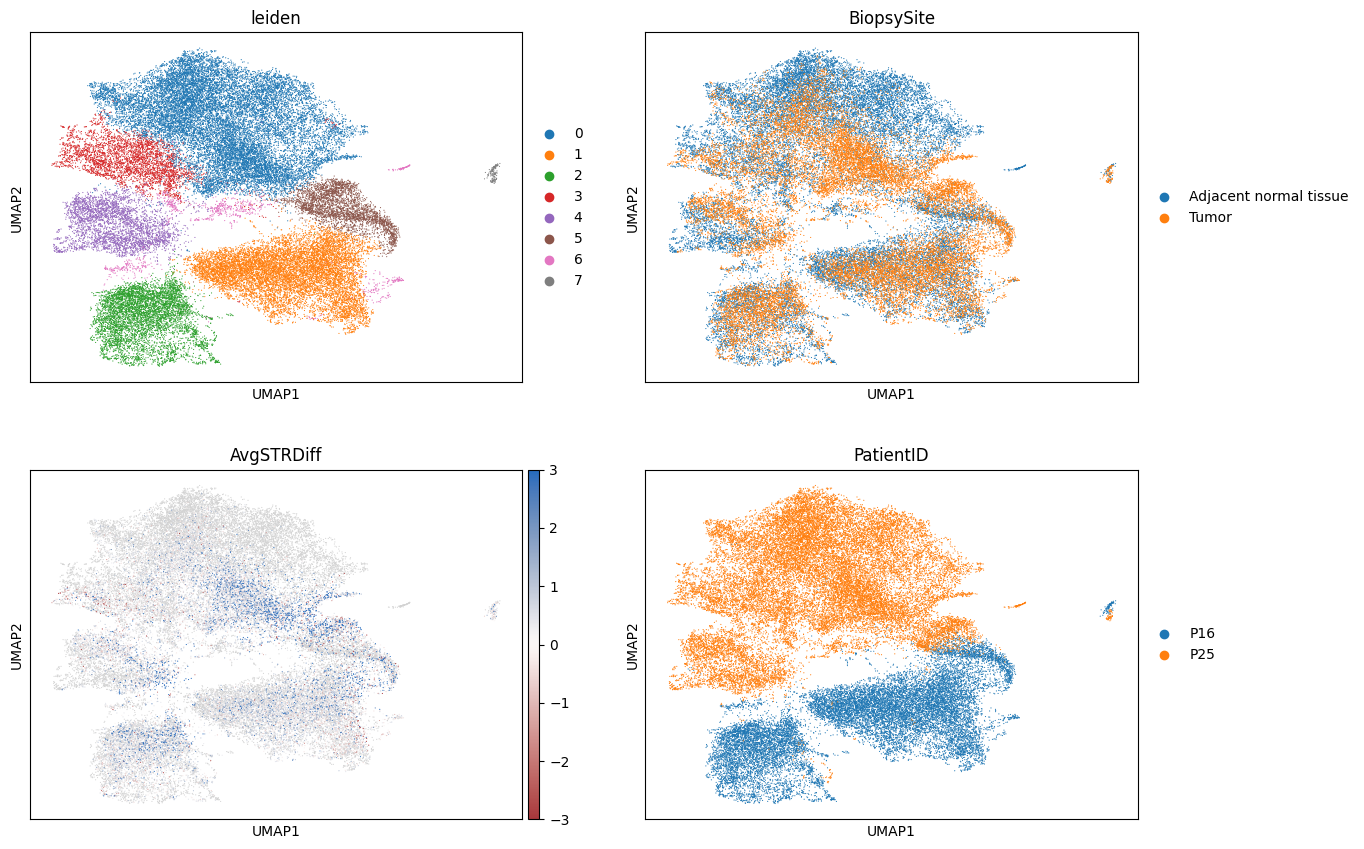

In [112]:
sc.pl.umap(adata_epi, color=['leiden', 'BiopsySite', 'AvgSTRDiff', 'PatientID'], 
           ncols=2, 
           vmin=-3, vmax=3, cmap='vlag_r')

<Axes: xlabel='AvgSTRDiff', ylabel='leiden'>

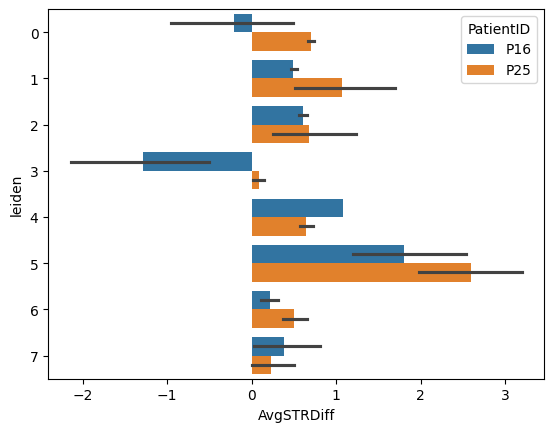

In [117]:
sns.barplot(data=adata_epi[adata_epi.obs['NumSTRLoci']>5].obs, y='leiden', x='AvgSTRDiff', hue='PatientID')

In [109]:
sc.tl.rank_genes_groups(adata_epi, groupby='leiden', method='logreg')

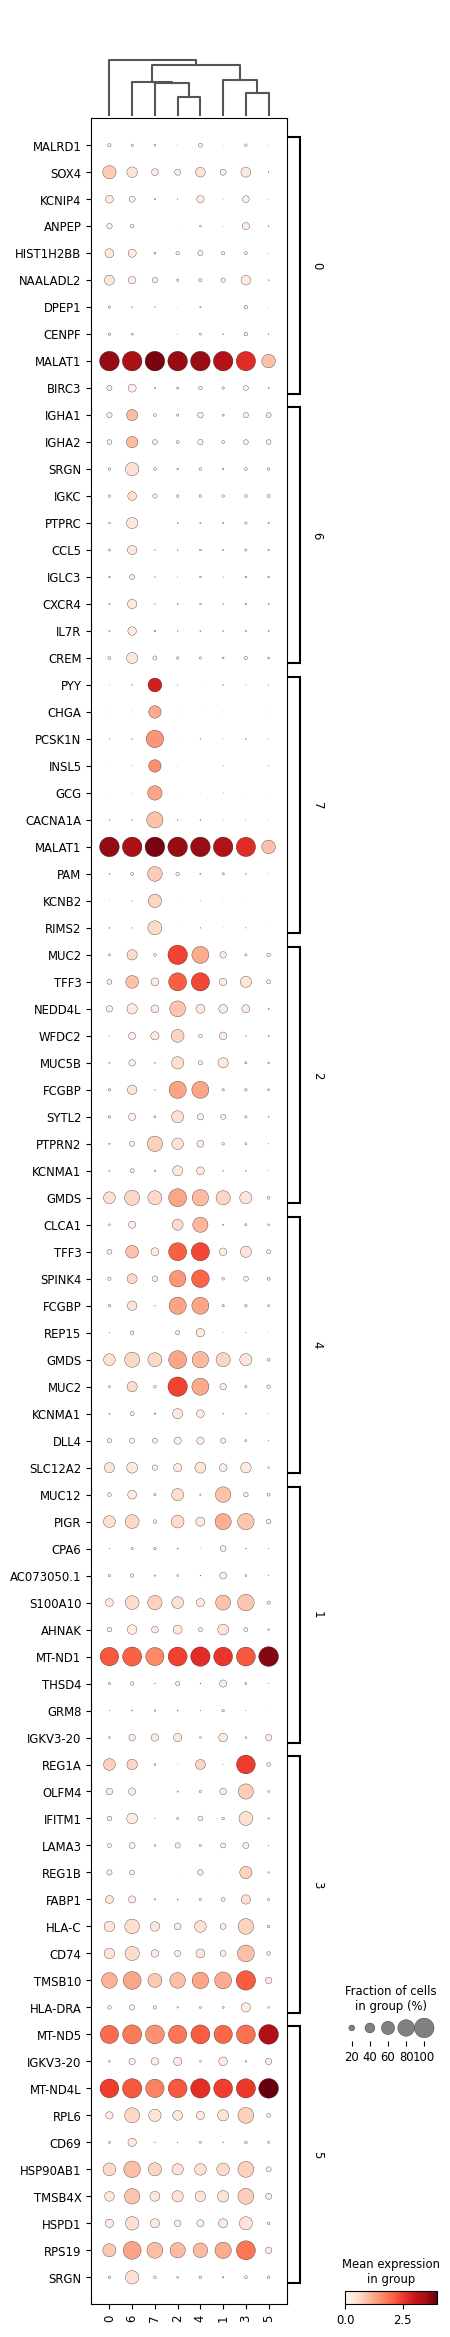

In [114]:
sc.pl.rank_genes_groups_dotplot(adata_epi, groupby='leiden', swap_axes=True)

In [ ]:
sc.pl.umap(adata_epi, color=['leiden', 'BiopsySite', 'AvgSTRDiff', 'PatientID'], 
           ncols=2, 
           vmin=-3, vmax=3, cmap='vlag_r')